Next steps:
1. Add a "master node" that connects all nodes together, so that message passing works between all nodes

In [1]:
import pandas as pd

from EmbedDataset import LigandBinaryDataset

import time
import numpy as np
import torch
from torch_geometric.loader import DataLoader

In [2]:
dataset = LigandBinaryDataset('./data2/')

In [3]:
dataset = dataset.shuffle()
train_dataset = dataset[:int(len(dataset) * 0.7)]
val_dataset = dataset[int(len(dataset) * 0.7):int(len(dataset) * 0.85)]
test_dataset = dataset[int(len(dataset) * 0.85):]

In [4]:
train_dl = DataLoader(train_dataset, batch_size=16)
val_dl = DataLoader(val_dataset, batch_size=16)
test_dl = DataLoader(test_dataset, batch_size=16)

In [10]:
from LigandGNNV2 import LigandGNNV2
from LigandGNNV1 import LigandGNNV1
from sagn.models import SAGN

device = torch.device('cuda')
# model = LigandGNNV1(dataset.num_node_features, 1).to(device)
# model = LigandGNNV2(128, 45).to(device)
model = SAGN(in_feats=1070, hidden=1024, out_feats=1, num_hops=3, n_layers=2, num_heads=1, dropout=0.15).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([22]).to(device))

In [11]:
def train(model, loader, criterion, optimizer):
    model.train()

    loss_acc = 0.
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y

        loss = criterion(output, label.reshape(-1, 1))
        loss.backward()
        loss_acc += data.num_graphs * loss.item()
        optimizer.step()

    return loss_acc / len(loader.dataset)

In [12]:
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, auc, precision_recall_fscore_support, roc_auc_score

def evaluate(model, loader):
    model.eval()

    preds = np.asarray([])
    labels = np.asarray([])

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = torch.sigmoid(model(data).round().squeeze().cpu()).round().numpy()
            label = data.y.cpu().numpy()

            preds = np.concatenate([preds, pred])
            labels = np.concatenate([labels, label])

    precision, recall, _ = precision_recall_curve(labels, preds)
    fpr, tpr, thresholds = roc_curve(labels, preds, pos_label=1)
    print(precision_recall_fscore_support(labels, preds))
    return auc(fpr, tpr), auc(recall, precision)
    return roc_auc_score(labels, preds)

In [13]:
train_hist = []
val_hist = []

for epoch in range(1, 201):
    s = time.time()
    loss = train(model, train_dl, criterion, optimizer)
    train_score = evaluate(model, train_dl)
    val_score = evaluate(model, val_dl)
    scheduler.step(loss)
    e = time.time()

    train_hist.append(train_score)
    val_hist.append(val_score)

    if sum(val_score) > (.77 + .44) and sum(val_score) >= np.asarray(val_hist).sum(axis=1).max():
        print("saving...")
        torch.save(model.state_dict(), './models/BestModel5.pt')

    # print(f'Epoch: {epoch:03d}, Loss: {loss:.05f}, Train Score: {train_score:.05f}, Val Score: {val_score:.05f}, Time: {e - s:.05f}s')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.05f}, Train Score: {train_score}, Val Score: {val_score}, Time: {e - s:.05f}s')

(array([0.98284627, 0.14022583]), array([0.8649082 , 0.59342753]), array([0.92011337, 0.22684792]), array([339310,  12598], dtype=int64))
(array([0.98206749, 0.14143407]), array([0.87293455, 0.56769596]), array([0.92429078, 0.22645085]), array([68508,  2526], dtype=int64))
Epoch: 001, Loss: 1.19910, Train Score: (0.7291678621119955, 0.37410415026946914), Val Score: (0.7203152548926443, 0.3622514742406846), Time: 2.69000s
(array([0.98248574, 0.19321719]), array([0.91292329, 0.56167646]), array([0.94642803, 0.2875254 ]), array([339310,  12598], dtype=int64))
(array([0.98177794, 0.19720971]), array([0.91936708, 0.53721298]), array([0.9495481 , 0.28850856]), array([68508,  2526], dtype=int64))
Epoch: 002, Loss: 0.92149, Train Score: (0.7372998710357767, 0.38529262482312776), Val Score: (0.7282900330866225, 0.3754398004036582), Time: 2.55600s
(array([0.98347483, 0.24009493]), array([0.93205623, 0.57818701]), array([0.95707541, 0.3392957 ]), array([339310,  12598], dtype=int64))
(array([0.98

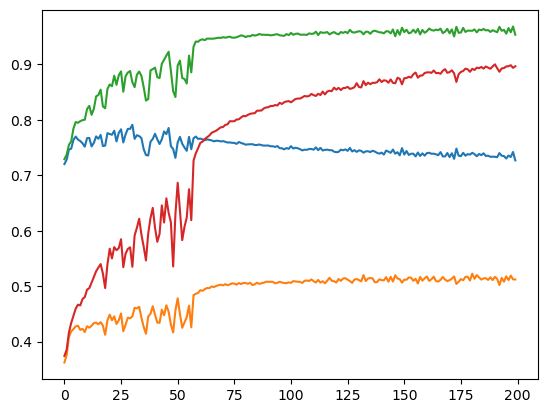

In [14]:
import matplotlib.pyplot as plt
plt.plot(val_hist)
plt.plot(train_hist)
plt.show()

In [15]:
evaluate(model, test_dl)

(array([0.98507711, 0.51290794]), array([0.98612922, 0.4943662 ]), array([0.98560288, 0.50346641]), array([72094,  2130], dtype=int64))


(0.7402477086839286, 0.5108921341387699)

In [17]:
model.load_state_dict(torch.load('./models/BestModel5.pt'))
evaluate(model, test_dl)

(array([0.98693617, 0.41568355]), array([0.97664161, 0.56244131]), array([0.9817619 , 0.47805267]), array([72094,  2130], dtype=int64))


(0.7695414606725622, 0.4953407265565653)

In [ ]:
data = test_dl.dataset[4].to(device)

In [ ]:
pred = model(data)

In [ ]:
out = torch.sigmoid(pred).round()
out

In [ ]:
print(out.sum())
print(len(out))

In [ ]:
len(data.y) / data.y.sum()

In [ ]:
data.y.sum()

In [ ]:
f1_score(data.y.detach().cpu().numpy(), out.detach().cpu().numpy())

In [ ]:
torch.save(model.state_dict(), './models/modelBest.pt')